In [6]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
from skimage.transform import resize
import os

CHANNELS = ['red', 'green', 'blue', 'yellow']

In [7]:
class CellDataset(object):
    '''Dataset class to fetch HPA cell-level images
    and corresponding weak labels
    '''
    def __init__(self, images, targets, img_root, augmentations=None):
        self.images = images
        self.targets = targets
        self.img_root = img_root
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = self.images[idx] 
        img_channels = self._fetch_channels(img_id)
        features = self._channels_2_array(img_channels)
        features = resize(features, (512, 512))  # Resize cell images for collate function
        # Adjust to channel first indexing for pytorch (speed reasons)
        features = np.transpose(features, (2, 0, 1)).astype(np.float32)
        # Grab target vector
        target = self.targets[idx]
        
        return {'image': torch.tensor(features),
                'target': torch.tensor(target)
                }
    
    def _fetch_channels(self, img_id: str, channel_names=CHANNELS):
        'Return absolute path of segmentation channels of a given image id'
        base = os.path.join(self.img_root, img_id)
        return [base + '_' + i  + '.png' for i in channel_names]
                                         
    def _channels_2_array(self, img_channels):
        'Return 3D array of pixel values of input image channels'
        # Init and reshape single channel array so we can concat other channels
        channel_1 = np.array(Image.open(img_channels[0]))
        shape = channel_1.shape + (1,)  
        pixel_arr = channel_1.reshape(shape)
        # Lay out 4 channels in 3D array for model input
        for channel in img_channels[1:3]:
            channel_values = np.array(Image.open(channel)).reshape(shape)
            pixel_arr = np.concatenate([pixel_arr, channel_values], axis=2)
        return pixel_arr

In [8]:
# Dataset class should be fed numpy arrays to index for speed reasons (apparently)
def extract_as_array(str_):
    list_ = str_.strip('][').split(', ')
    return np.array([int(i) for i in list_])

train_csv = '../input/train_cells/train.csv'
df = pd.read_csv(train_csv, index_col=0)
images = df['cell_id'].values
targets = df['Label'].apply(extract_as_array).values

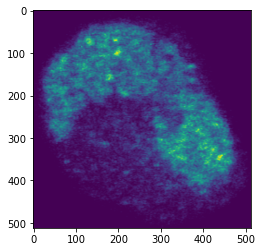

In [9]:
cells = CellDataset(images, targets, '../input/train_cells')

import matplotlib.pyplot as plt
cells[0]['target']
plt.imshow(cells[0]['image'][1, :, :]) # Proteins

(236, 248)


0.0022125582

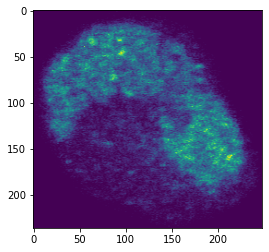

In [8]:
import matplotlib.pyplot as plt
img = plt.imread('../input/train_cells/5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_1_green.png')
print(img.shape)
plt.imshow(img)
img.max()